### Goal : Predict whether a patient is likely to get stroke  based on the below mentioned features

#### Features

1) id: unique identifier

2) gender: "Male", "Female", "Other"

3) age: Patient's age

4) hypertension: 0 = patient doesn't have hypertension, 1 = patient has hypertension

5) heart_disease: 0 =  patient doesn't have any heart diseases, 1 = patient has a heart disease

6) ever_married: "No" ,"Yes"

7) work_type: "children", "Govt_jov", "Never_worked", "Private" , "Self-employed"

8) Residence_type: "Rural" , "Urban"

9) avg_glucose_level: average blood glucose level

10) bmi: body mass index

11) smoking_status: "formerly smoked", "never smoked", "smokes" / "Unknown"*

12) stroke: 1 = patient had a stroke, 1 = patient did not have a stroke

In [41]:
#pip install seaborn
#pip install scikit-learn
#!pip install imbalanced-learn
#!pip install gcsfs

In [106]:
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation libraries
import pandas as pd
import numpy as np

# Data Visualization and analysis libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Data pre-processing libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split

# Module for machine learning hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Model building 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


# Model evaulation libraries
from sklearn.metrics import confusion_matrix , classification_report ,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Saving model
import pickle

from google.cloud import storage
import gcsfs

In [45]:
stroke_dataset = pd.read_csv('gs://cloud-ai-platform-92295410-070a-449f-89d7-c6cd2ed9a7b1/healthcare-dataset-stroke-data.csv')
stroke_dataset

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


#### Observation

#### Target 
stroke : in binary format , where '1' indicated patient had stoke and '0' indicated that patient didnt have stoke 

#### Features 
'gender', 'age', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'

#### Binary format features 
hypertension,heart_disease,stroke

#### Other categorical variables 
gender, ever_married , work_type , residence_type , smoking status 

#### Numerical features 
age , avg_glucose_level , bmi, id 

#### Exploratory Data Analysis and Preprocessing

In [46]:
# Since id is a unique identifier , it will not explain the variability in the target ,so we can drop it
stroke_dataset.drop('id', axis=1, inplace=True)

In [47]:
#  Displaying number of rows and columns of the dataset
stroke_dataset.shape
print("Total number of rows : ", stroke_dataset.shape[0])
print("Total number of columns : " , stroke_dataset.shape[1])

Total number of rows :  5110
Total number of columns :  11


In [48]:
# Information about the dataset
stroke_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


#### Exploring target variable - stroke

In [49]:
print(stroke_dataset['stroke'].value_counts())

0    4861
1     249
Name: stroke, dtype: int64


Text(0.5, 1.0, 'Stroke Event %')

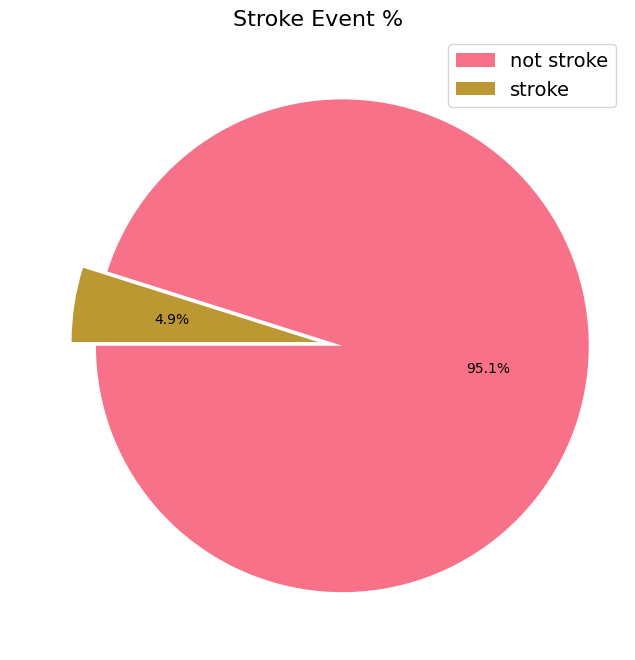

In [50]:
stroke_dataset['stroke'] = stroke_dataset['stroke'].astype(float)
colors = sns.set_palette('husl')
plt.figure(figsize=(18,8))
pie = stroke_dataset['stroke'].value_counts()
plt.pie(pie, colors=colors, autopct='%.1f%%', wedgeprops={'linewidth':3}, explode=[0.1,0],startangle=180)
plt.legend(['not stroke', 'stroke'], fontsize=14)
plt.title('Stroke Event %', fontsize=16)

#### Observation 
We can observe that only 4.9% of the entire dataset is the data of patients with stroke , thus it is a highly imbalanced datasets

#### Exploring other features 

In [51]:
# Identifying distirbution of missing values in the dataset
percentage = pd.DataFrame()
percentage["# Missing values"] = stroke_dataset.isna().sum()
percentage['% Missing Values'] = round((stroke_dataset.isna().sum()/stroke_dataset.shape[0])*100,2)
percentage

,# Missing values,% Missing Values
gender,0,0.00
age,0,0.00
hypertension,0,0.00
heart_disease,0,0.00
ever_married,0,0.00
work_type,0,0.00
Residence_type,0,0.00
avg_glucose_level,0,0.00
bmi,201,3.93
smoking_status,0,0.00


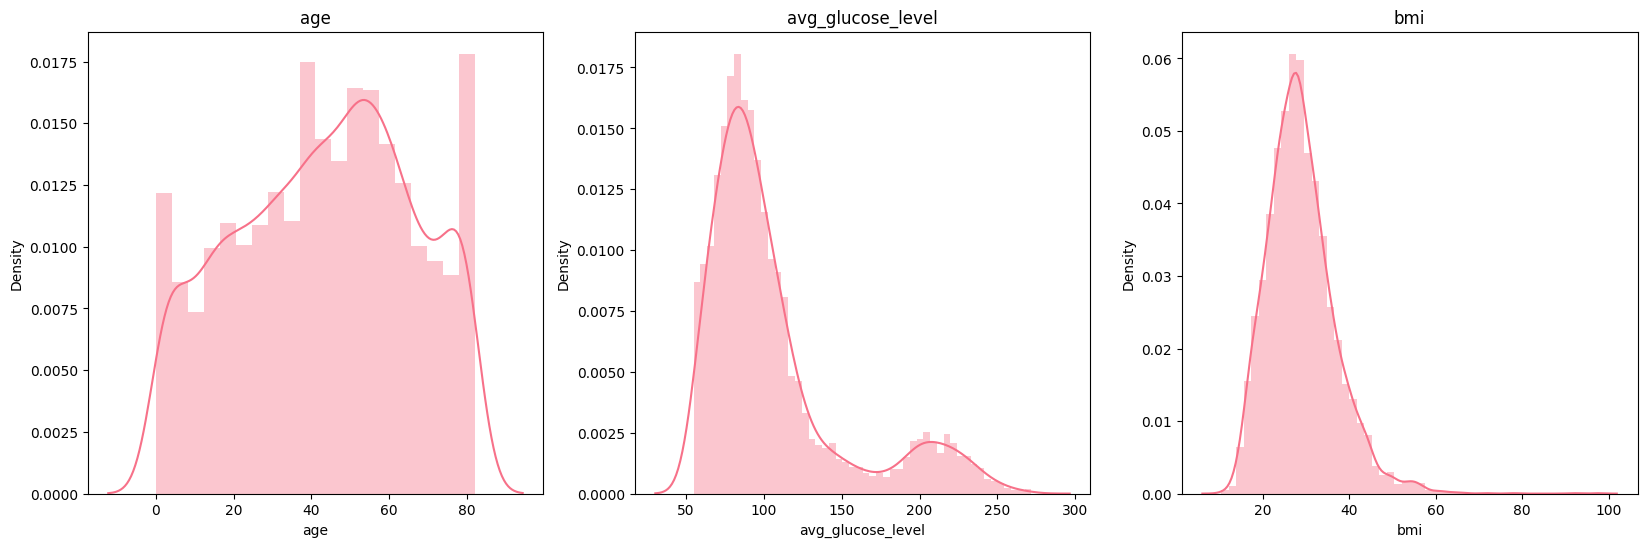

In [52]:
# Analysing distribution of numerical features
stroke_dataset[['age', 'avg_glucose_level', 'bmi']] = stroke_dataset[['age', 'avg_glucose_level', 'bmi']].astype(float)
numerical_features = ['age', 'avg_glucose_level', 'bmi']
plt.subplots(1,3, figsize=(20,6))
for i in range(3):
    plt.subplot(1,3, i+1)
    sns.distplot(stroke_dataset[numerical_features[i]])
    plt.title(f"{numerical_features[i]}")


##### Observation 
We can observe that 'age' is normally distributed while 'avg_glucose_level' and 'bmi' and rightly skewed.

In [53]:
# Since bmi has a skewed distirbuton and has missing values, the best method is to impute the missing values with median
stroke_dataset['bmi'] = stroke_dataset['bmi'].fillna(stroke_dataset['bmi'].median())

In [54]:
stroke_dataset

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1.0
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1.0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1.0
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1.0
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0.0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0.0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0.0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0.0


In [55]:
# Exploring distribution of categorical features
categorical_features = stroke_dataset[['stroke','gender','hypertension','heart_disease','work_type','Residence_type','smoking_status']]
categorical_features_summary = pd.concat([pd.crosstab(categorical_features[x], categorical_features.stroke) for x in categorical_features.columns[:-1]], keys=categorical_features.columns[:-1])
categorical_features_summary

stroke                         0.0  1.0
stroke         0.0            4861    0
               1.0               0  249
gender         Female         2853  141
               Male           2007  108
               Other             1    0
hypertension   0.0            4429  183
               1.0             432   66
heart_disease  0.0            4632  202
               1.0             229   47
work_type      Govt_job        624   33
               Never_worked     22    0
               Private        2776  149
               Self-employed   754   65
               children        685    2
Residence_type Rural          2400  114
               Urban          2461  135

#### Exploring relationship between the target feature 'stroke' with patient's other feature

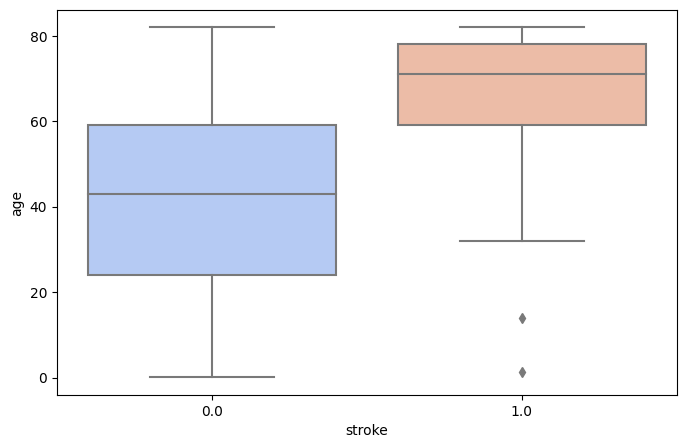

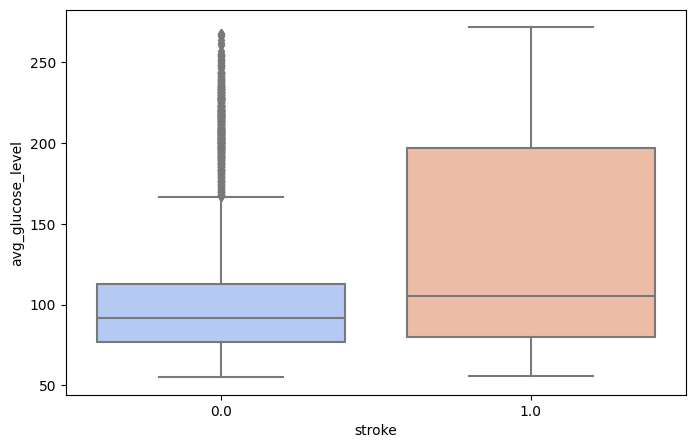

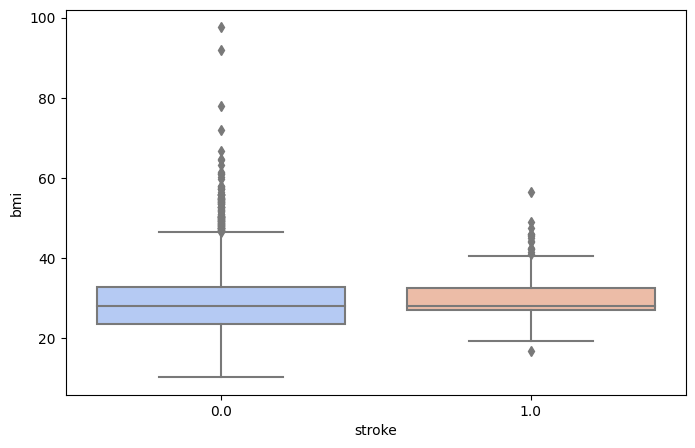

In [56]:
stroke_dataset[['stroke','age', 'avg_glucose_level', 'bmi']]=stroke_dataset[['stroke','age', 'avg_glucose_level', 'bmi']].astype(float)
def boxplot(x):
    plt.figure(figsize=(8,5))
    sns.boxplot(data=stroke_dataset, x="stroke",y=stroke_dataset[x],palette="coolwarm")
    plt.show()

num_features = ['age', 'avg_glucose_level', 'bmi']
for i in num_features:
    boxplot(i)

In [57]:
stroke_dataset

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1.0
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1.0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1.0
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1.0
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0.0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0.0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0.0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0.0


In [58]:
# Label encoding for categorical variable
label_encoder = LabelEncoder()
stroke_dataset['ever_married'] = label_encoder.fit_transform(stroke_dataset['ever_married'])
label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.transform(label_encoder.classes_)))
print("Mapping of Label Encoded classes of ever_married", label_encoder_name_mapping, sep="\n")

stroke_dataset['gender'] = label_encoder.fit_transform(stroke_dataset['gender'])
label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.transform(label_encoder.classes_)))
print("Mapping of Label Encoded classes of gender", label_encoder_name_mapping, sep="\n")

stroke_dataset['work_type'] = label_encoder.fit_transform(stroke_dataset['work_type'])
label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.transform(label_encoder.classes_)))
print("Mapping of Label Encoded classes of work_type", label_encoder_name_mapping, sep="\n")


stroke_dataset['Residence_type'] = label_encoder.fit_transform(stroke_dataset['Residence_type'])
label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.transform(label_encoder.classes_)))
print("Mapping of Label Encoded classes of Residence_type", label_encoder_name_mapping, sep="\n")


stroke_dataset['smoking_status'] = label_encoder.fit_transform(stroke_dataset['smoking_status'])
label_encoder_name_mapping = dict(zip(label_encoder.classes_,
                                         label_encoder.transform(label_encoder.classes_)))
print("Mapping of Label Encoded classes of smoking_status", label_encoder_name_mapping, sep="\n")

Mapping of Label Encoded classes of ever_married
{'No': 0, 'Yes': 1}
Mapping of Label Encoded classes of gender
{'Female': 0, 'Male': 1, 'Other': 2}
Mapping of Label Encoded classes of work_type
{'Govt_job': 0, 'Never_worked': 1, 'Private': 2, 'Self-employed': 3, 'children': 4}
Mapping of Label Encoded classes of Residence_type
{'Rural': 0, 'Urban': 1}
Mapping of Label Encoded classes of smoking_status
{'Unknown': 0, 'formerly smoked': 1, 'never smoked': 2, 'smokes': 3}


#### Observation : One other observation in the dataset is the scale variation in dataset , thus we will be converting the scale into the range of 0 and 1 ( This helps to avoid bias towards any variable )

In [59]:
stroke_dataset

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1.0
1,0,61.0,0,0,1,3,0,202.21,28.1,2,1.0
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1.0
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1.0
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,28.1,2,0.0
5106,0,81.0,0,0,1,3,1,125.20,40.0,2,0.0
5107,0,35.0,0,0,1,3,0,82.99,30.6,2,0.0
5108,1,51.0,0,0,1,2,0,166.29,25.6,1,0.0


In [60]:
stroke_dataset[['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']] = stroke_dataset[['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']].astype('float')

In [61]:
# Min max scaling of the features
features = stroke_dataset.drop('stroke',axis = 1)
features_min = features.min()
features_max = features.max()
dataset = ( features - features_min)/(features_max - features_min)
dataset ['stroke'] = stroke_dataset['stroke']
dataset

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0.5,0.816895,0.0,1.0,1.0,0.50,1.0,0.801265,0.301260,0.333333,1.0
1,0.0,0.743652,0.0,0.0,1.0,0.75,0.0,0.679023,0.203895,0.666667,1.0
2,0.5,0.975586,0.0,1.0,1.0,0.50,0.0,0.234512,0.254296,0.666667,1.0
3,0.0,0.597168,0.0,0.0,1.0,0.50,1.0,0.536008,0.276060,1.000000,1.0
4,0.0,0.963379,1.0,0.0,1.0,0.75,0.0,0.549349,0.156930,0.666667,1.0
...,...,...,...,...,...,...,...,...,...,...,...
5105,0.0,0.975586,1.0,0.0,1.0,0.50,1.0,0.132167,0.203895,0.666667,0.0
5106,0.0,0.987793,0.0,0.0,1.0,0.75,1.0,0.323516,0.340206,0.666667,0.0
5107,0.0,0.426270,0.0,0.0,1.0,0.75,0.0,0.128658,0.232532,0.666667,0.0
5108,0.5,0.621582,0.0,0.0,1.0,0.50,0.0,0.513203,0.175258,0.333333,0.0


In [63]:
stroke_dataset =dataset.copy()
X=stroke_dataset.drop(['stroke'],axis=1)
y=stroke_dataset['stroke']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.10)

In [64]:
# Dealing with inbalanced data
sm = SMOTE(k_neighbors=5, random_state=123)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)
print('Before OverSampling, the shape of X_train: {}'.format(X_train.shape))
print('Before OverSampling, the shape of y_train: {}'.format(y_train.shape)) 
print('After OverSampling, the shape of X_train_over: {}'.format(X_train_over.shape))
print('After OverSampling, the shape of y_train_over: {}'.format(y_train_over.shape))

Before OverSampling, the shape of X_train: (4599, 10)
Before OverSampling, the shape of y_train: (4599,)
After OverSampling, the shape of X_train_over: (8752, 10)
After OverSampling, the shape of y_train_over: (8752,)


### Model Development 

#### Model 1 : Logistic Regression

In [73]:
LogisticRegression_model = LogisticRegression()
LogisticRegression_model.fit(X_train_over, y_train_over)
# Prediction values 
y_pred_lr = LogisticRegression_model.predict(X_test)

#### Model 2 : Random Forest Classifier

In [74]:
RandomForestClassifier_model = RandomForestClassifier()
RandomForestClassifier_model.fit(X_train_over, y_train_over)
# Prediction values 
y_pred_rf = RandomForestClassifier_model.predict(X_test)

In [46]:
# Hyperparameter tuning
n_estimators = [100,250,500] # number of trees ensembles in random forest 
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum depth of each tree
min_samples_split = [4, 6, 8] # sample number to split a node
min_samples_leaf = [2, 4 , 6] # minimum number of leaf nodes
bootstrap = [True, False] 

random_grid = {'n_estimators': n_estimators,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=0, random_state= 50, n_jobs = -1)
rf_random.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=70, min_samples_leaf=4, min_samples_split=4, n_estimators=250; total time=   3.0s
[CV] END bootstrap=True, max_depth=70, min_samples_leaf=4, min_samples_split=4, n_estimators=250; total time=   2.9s
[CV] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=   9.5s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=6, min_samples_split=4, n_estimators=500; total time=   9.3s
[CV] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=4, n_estimators=500; total time=   8.4s
[CV] END bootstrap=False, max_depth=120, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.7s
[CV] END bootstrap=False, max_depth=120, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   1.7s
[CV] END bootstrap=False, max_depth=120, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [4, 6, 8],
                                        'n_estimators': [100, 250, 500]},
                   random_state=50, verbose=2)

In [47]:
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Best Parameters:  {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 80, 'bootstrap': False}  



In [82]:
best_RandomForestClassifier = RandomForestClassifier(n_estimators = 500, min_samples_split = 4, min_samples_leaf= 2, max_depth= 20, bootstrap=False) 
best_RandomForestClassifier.fit(X_train_over, y_train_over)
y_pred_rf_best = best_RandomForestClassifier.predict(X_test)

#### Model 3 : Support Vector Machine Classifier 

In [110]:
svc=SVC() 
support_vector_classifier = svc.fit(X_train_over, y_train_over)
# make predictions on test set
y_pred_support_vector = support_vector_classifier.predict(X_test)

#### Model 4 : Naive Bayes Classifier 

In [111]:
gnb = GaussianNB()
naive_bayes_classifier = gnb.fit(X_train_over, y_train_over)
y_pred_naive_bayes_ = naive_bayes_classifier.predict(X_test)

#### Model 4: Neural Network

In [75]:
# Modules for neural network  
#pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [77]:
# Define ANN model
ANN_model_all_features = Sequential()

# Define input layer 
ANN_model_all_features.add(Dense(1000, input_shape=(X_train.shape[1],), activation='relu')) 

# Define hidden layers
ANN_model_all_features.add(Dense(500, activation='relu'))
ANN_model_all_features.add(Dropout(0.5)) 
ANN_model_all_features.add(Dense(250, activation='relu'))
ANN_model_all_features.add(Dropout(0.5)) 

# Define output layer 
ANN_model_all_features.add(Dense(1, activation='linear')) 
ANN_model_all_features.summary() 

# compile the model
ANN_model_all_features.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

history = ANN_model_all_features.fit(X_train_over, y_train_over,
                    validation_data = (X_train_over, y_train_over),
                    callbacks=[es],
                    epochs=5000,
                    batch_size=50,
                    verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1000)              11000     
                                                                 
 dense_13 (Dense)            (None, 500)               500500    
                                                                 
 dropout_6 (Dropout)         (None, 500)               0         
                                                                 
 dense_14 (Dense)            (None, 250)               125250    
                                                                 
 dropout_7 (Dropout)         (None, 250)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 251       
                                                                 
Total params: 637,001
Trainable params: 637,001
Non-tr

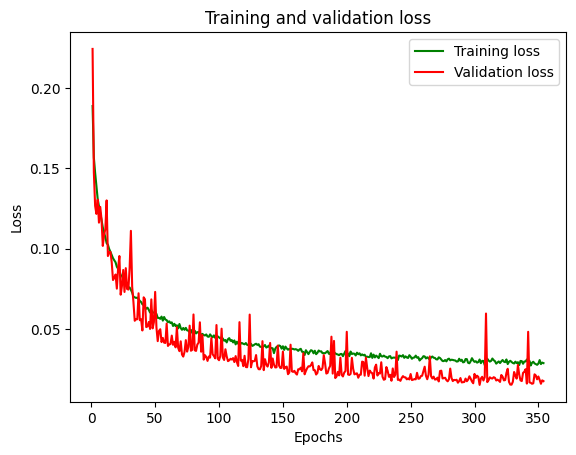

In [79]:
# Training and validation accuracy for each epoch
history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'green', label='Training loss')
plt.plot(epochs, val_loss_values, 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [95]:
# predict probabilities for test set
yhat_probs = ANN_model_all_features.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes=np.argmax(yhat_probs,axis=1)

# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

### Model Evaluation and comparison

In [147]:
# Logistic Regression
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85       485
         1.0       0.12      0.65      0.21        26

    accuracy                           0.74       511
   macro avg       0.55      0.70      0.53       511
weighted avg       0.93      0.74      0.81       511

[[363 122]
 [  9  17]]


In [148]:
# Random Forest Classifier 
print(classification_report(y_test, y_pred_rf_best))
print(confusion_matrix(y_test, y_pred_rf_best))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       485
         1.0       0.07      0.08      0.07        26

    accuracy                           0.90       511
   macro avg       0.51      0.51      0.51       511
weighted avg       0.91      0.90      0.90       511

[[457  28]
 [ 24   2]]


In [149]:
# Support Vector Machine Classifier 
print(classification_report(y_test, y_pred_support_vector))
print(confusion_matrix(y_test, y_pred_support_vector))

              precision    recall  f1-score   support

         0.0       0.97      0.78      0.86       485
         1.0       0.11      0.54      0.19        26

    accuracy                           0.76       511
   macro avg       0.54      0.66      0.52       511
weighted avg       0.93      0.76      0.83       511

[[376 109]
 [ 12  14]]


In [150]:
# Naive Bayes Classifier 
print(classification_report(y_test, y_pred_naive_bayes_))
print(confusion_matrix(y_test, y_pred_naive_bayes_))

              precision    recall  f1-score   support

         0.0       0.98      0.74      0.84       485
         1.0       0.12      0.65      0.20        26

    accuracy                           0.74       511
   macro avg       0.55      0.70      0.52       511
weighted avg       0.93      0.74      0.81       511

[[359 126]
 [  9  17]]


In [151]:
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)

Accuracy: 0.949119


### Identifying most important features

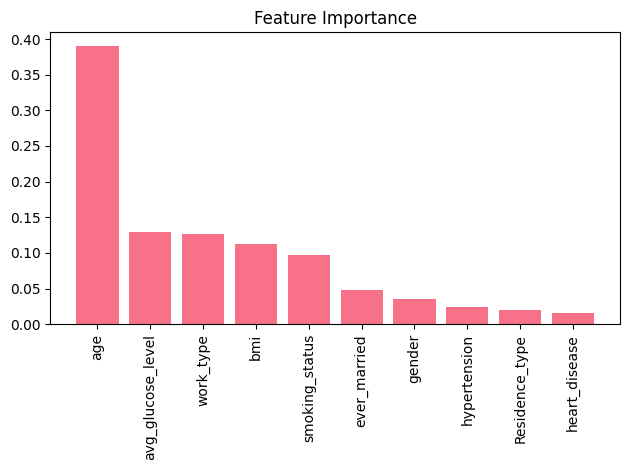

In [50]:
importances = best_RandomForestClassifier.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

#### Saving model to bucket

#### Deploying the model

In [156]:
import pickle

In [157]:
pickle.dump(best_RandomForestClassifier,open('model.pkl','wb'))

In [158]:
# Loading the model 
import os
model = pickle.load(open('model.pkl', 'rb'))

In [159]:
artifact_filename = 'model.pkl'
local_path = artifact_filename

In [160]:
# Upload model artifact to Cloud Storage
model_directory = "gs://cloud-ai-platform-92295410-070a-449f-89d7-c6cd2ed9a7b1"
storage_path = os.path.join(model_directory, artifact_filename)
blob = storage.blob.Blob.from_string(storage_path, client=storage.Client())
blob.upload_from_filename(local_path)

In [161]:
# Convert series into array
minimum =  np.array(features_min.values.tolist())
maximum = np.array(features_max.values.tolist())

### Predicting a single input

### Required input parameter for columns from the web interface
1. Gender : Male, Female , Other
2. Age : Numrical value
3. hypertension : Yes , No
4. heart_disease : Yes , No 
5. ever_married
6. work_type
7. Residence_type 
8. avg_glucose_level
9. bmi
10. smoking_status

In [162]:
input = ['Male',67.0,'No','Yes','Yes','Private','Urban',228.69,36.6,'formerly smoked']
encoded_values = {'No': 0, 'Yes': 1,'Female': 0, 'Male': 1, 'Other': 2,'Govt_job': 0, 'Never_worked': 1, 'Private': 2, 'Self-employed': 3, 'children': 4,'Rural': 0, 'Urban': 1,'Unknown': 0, 'formerly smoked': 1, 'never smoked': 2, 'smokes': 3}
for index in range(len(input)):
    if input[index] in encoded_values.keys():
        input[index] = encoded_values[input[index] ]
# Scaling the sample value
input_scaled =( input - minimum)/(maximum - minimum)
predict = model.predict([input_scaled])
if(predict == 1):
    print("Patient is likely to have a stroke")
else:
    print("Patient is not likely to have a stroke")

Patient is likely to have a stroke


#### Output matches the ground truth of first row

{
  "instances":[[0.5,0.81689453125,0.0,1.0,1.0,0.5,1.0,0.8012648878219923,0.3012600229095075, 0.3333333333333333]]
}